In [1]:
import gradio as gr 

In [92]:
import os
import random
import shutil
import numpy as np
from scipy import ndimage
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import tensorflow as tf 

In [9]:
dataset_with_mask = r"C:\Users\karan\Documents\Dataset\with_mask"
dataset_without_mask = r"C:\Users\karan\Documents\Dataset\without_mask" 

In [93]:
# I am currently going to store all teh images in the form of an array with their respective classes so that I can label them 
# accordingly
def store_iamge_data(path,label):
    data=[]
    for name in os.listdir(path):
        if name.endswith('.jpg'):
            image= load_img(os.path.join(path,name),target_size=(80,80))
            image_array = img_to_array(image) 
            image_tensor = tf.convert_to_tensor(image_array)
            data.append({'image':image_tensor,'label':tf.convert_to_tensor([label])})
    return data 

In [94]:
with_mask_data=store_iamge_data(dataset_with_mask,0)# if you have the mask your label is 0
without_mask_data =store_iamge_data(dataset_without_mask,1) # if you are without mask you have the label 1

In [95]:
with_mask_data.extend(without_mask_data)

In [96]:
import pandas as pd 

In [97]:
data = pd.DataFrame(with_mask_data) 

In [100]:
# Here we can see that the we have both the data's stored as an array in a given dataframe now we just need to train our model

In [103]:
def scale_image(data):
    return data/255

In [104]:
data['image']=data['image'].apply(scale_image) # here we have scaled the data 

In [105]:
data=data.sample(frac=1.0).reset_index(drop=True) # it will shuffle all the data 

In [106]:
# 16000 images are too much to work with therefore I am only taking the first shuffled 8000 images

In [107]:
data = data[:8000] # only taking half of the data for training and testing 

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
X_train,X_test,y_train,y_test=train_test_split(data['image'],data['label'],test_size=0.2)

In [110]:
import matplotlib.pyplot as plt 
%matplotlib inline

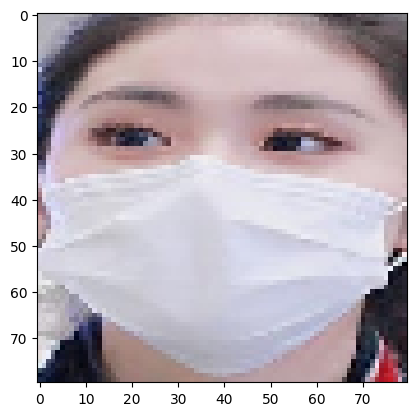

In [111]:
plt.imshow(X_train[4300])
plt.show() 
# we can see that we have the images with us 

In [112]:
X_train[4300].shape  

TensorShape([80, 80, 3])

In [114]:
y_train[4300] # and we know that the label 0 is with mask 

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>

In [124]:
X_train= tf.stack(X_train.reset_index(drop=True)).numpy()

In [127]:
y_train =tf.stack(y_train.reset_index(drop=True)).numpy() 

In [129]:
y_test =tf.stack(y_test.reset_index(drop=True)).numpy() 

In [130]:
X_test =tf.stack(X_test.reset_index(drop=True)).numpy() 

In [138]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape of images
input_shape = (80, 80, 3)

model = models.Sequential([
    layers.Conv2D(28, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(14, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(7, activation='relu'),
    layers.Dropout(0.2), 
    layers.Dense(1, activation='sigmoid')  # Binary classification output (mask or no mask)
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 78, 78, 28)        784       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 39, 39, 28)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 14)        3542      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 14)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 4536)              0         
                                                                 
 dense_10 (Dense)            (None, 7)                

In [140]:
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test),batch_size=32) 
# Model Training took about 1 hour 

Epoch 1/5
200/200 [==============================] - 460s 2s/step - loss: 0.3206 - accuracy: 0.8716 - val_loss: 0.1958 - val_accuracy: 0.9375
Epoch 2/5
200/200 [==============================] - 460s 2s/step - loss: 0.2083 - accuracy: 0.9356 - val_loss: 0.1562 - val_accuracy: 0.9488
Epoch 3/5
200/200 [==============================] - 443s 2s/step - loss: 0.1802 - accuracy: 0.9489 - val_loss: 0.1396 - val_accuracy: 0.9513
Epoch 4/5
200/200 [==============================] - 439s 2s/step - loss: 0.1564 - accuracy: 0.9573 - val_loss: 0.1398 - val_accuracy: 0.9488
Epoch 5/5
200/200 [==============================] - 450s 2s/step - loss: 0.1457 - accuracy: 0.9644 - val_loss: 0.1323 - val_accuracy: 0.9525


In [142]:
metrics = pd.DataFrame(model.history.history) 

<Axes: >

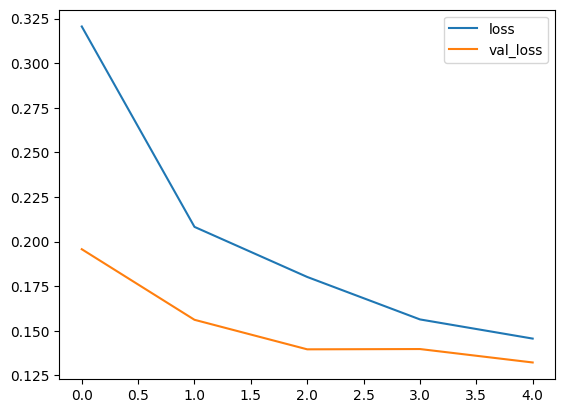

In [144]:
metrics[['loss','val_loss']].plot()     
# we can see that the model can be trained more for icreasing the accuracy.

In [146]:
model.save('mask_.h5')

In [148]:
preds = model.predict(X_test)

50/50 [==============================] - 10s 202ms/step


In [162]:
preds= np.where(preds>=0.5,1,0) 

In [163]:
preds

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

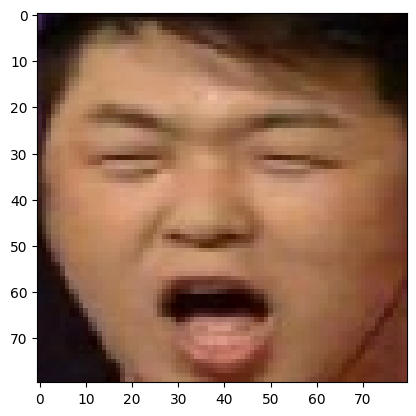

In [166]:
plt.imshow(X_test[0]) # whic is True basically.

In [185]:
from sklearn.metrics import accuracy_score 
from tensorflow.keras.models import load_model
import tensorflow as tf
from PIL import Image 

In [168]:
print(accuracy_score(y_test,preds)) # Here we can see that we have the accuracy of 0.9525 which is equal to validation accuracy.

0.9525


In [199]:
def predict(image):
    img = Image.fromarray(image.astype('uint8'), 'RGB')
    img = img.resize((80,80))
    img_tensor =tf.convert_to_tensor(tf.expand_dims(np.array(img.convert('RGB')),axis=0))      
    model = load_model('mask_.h5') 
    prediction = model.predict(img_tensor) 
    if prediction[0] >=0.5:
        return "With Mask" 
    else:
        return 'No Mask' 

In [201]:
demo =gr.Interface(predict,gr.Image(source='webcam',streaming=True),'text')  

In [202]:
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7873
Running on public URL: https://9554033bc5789ac668.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


In [ ]:
# Given This Image we can see that the model is correctly predicting that I am not wearing a mask